In [206]:
import kalman
import observation_helpers

reload(observation_helpers)



def ConstructFilter(csvfile, obs_noise, system_noise, start_obs=2000, 
                  stop_obs=2500, dt=.25, dim_u=0):
    '''
    Construct the Kalman filter instance for a cluster of sensors. 
    
    Parameters
    ----------
    csvfile : integer
        integer index of sensor in pandas dataframe.  
    obs_noise : np.array(z_dim, z_dim) (default=None)
        Specify the observation noise covariance matrix.  Scalar if z_dim=1 (observation dimension)
    system_noise : np.array(mu_dim, mu_dim)
        Specifies the system (process) covariance matrix mu_dim is the state dimension
    start_obs : integer
        Starting observation for estimating the initial baseline value
    stop_obs : integer
        Stopping observation for estimating the initial baseline value
    dt : float
        Time interval between observations
    dim_u : dimension of control input. 
    
    
    Returns 
    ----------
    K : Kalman instance. 
    '''
    # Get number of sensors in cluster.
    nsensors = observation_helpers.GetNumSensors(csvfile)
    
    # Get total observation vector. 
    Y = np.array([observation_helpers.GetTimeSeries(csvfile, i_sensor)
                                     for i_sensor in range(1,nsensors+1)])
    
    # Let's estimate the initial baseline using the median data points, excluding NaNs
    baselines = np.array([np.median(Y[i_sensor,start_obs:stop_obs][~np.isnan(Y[i_sensor,start_obs:stop_obs])])
                                     for i_sensor in range(0,nsensors)])

    # Label and enumerate the state parameters. 
    state_params = ['D', 'Ddot', 'b'] # These are for each sensor 
    nparams = len(state_params) # Number of parameters/sensor
    state_labels = [] # This will hold the full set of state labels
    for i_sensor in range(nsensors): 
        for param in state_params: 
            state_labels.append(param + '_%i'%i_sensor)

    #---------------------------------------------------
    # Construct the transition matrix
    A = np.zeros((nsensors*nparams, nsensors*nparams))
    
    # First, just couple a sensor to itself
    for i_sensor in range(nsensors): 
        for i_param, param in enumerate(state_params):
            # Setup Newton's equations for each sensor with itself.
            if param == 'D': 
                A[i_sensor*nparams+i_param, i_sensor*nparams+i_param+0] = 1  # Position
                A[i_sensor*nparams+i_param, i_sensor*nparams+i_param+1] = dt # Velocity update
                A[i_sensor*nparams+i_param+1, i_sensor*nparams+i_param+1] = 1 # Velocity update
            if param == 'b': 
                A[i_sensor*nparams+i_param, i_sensor*nparams+i_param+0] = 1  # Position

    # First observation that is not nan 
    Y0 = np.array([Y[i_sensor, np.argwhere(~np.isnan(Y[i_sensor]))[0]][0] for i_sensor in range(nsensors)])
    
    # Estimate initial state as first observation 
    mu_0 = [] 
    for i_sensor in range(nsensors):
        mu_0 += [-Y0[i_sensor]+baselines[i_sensor], 0., baselines[i_sensor]]
    mu_0 = np.array(mu_0)
    
    #-----------------------------------------------
    # Estimate for the initial state covariance.  
    # Assume diagonal, and identical uncertainties. 
    sigma_0 = np.diag((50, 10, 10)*nsensors)
    
    # Control Model 
    B = np.zeros((len(mu_0),dim_u))

    # Observation Matrix
    C = np.zeros((nsensors, len(mu_0)))
    for i_sensor in range(nsensors):
        C[i_sensor,:] = np.array([0, 0, 0]*i_sensor + [-1, 0, +1] + [0, 0, 0]*(nsensors-i_sensor-1))
    
    # Observation control matrix
    D = None
    
    # Process noise.
    Q = system_noise
    
    # Observation Noise
    R = obs_noise 

    K = kalman.Kalman(mu_0, sigma_0, A, B, C, D, Q, R, state_labels)

    return K 



def AugmentFilterDifferentialTracking(K, process_noise, dt=.25):
    '''
    Expand the matrices in the Kalman filter to accomodate the pairwise displacement observations.
    
    The observation length expands by: n_sensors*(n_sensors-1)/2
    The state length expands by: n_sensors*(n_sensors-1)  (difference and velocity)
    
    Parameters
    ----------
    
    K : Kalman filter instance. 
    
    process_noise : np.array(2)
        Tuple or array specifying the process noise level for each differential and differential velocity.
        Should probably be near [2*process_variance(d), 2*process_variance(v)]
    
    dt : float
        timestep
    
    Returns
    ----------
    
    K : Kalman filter instance. 
    '''
    nsensors = K.C.shape[0]
    # Number of parameters before expansion
    old_params = K.A.shape[0]
    # Number of new parameters
    new_params = nsensors*(nsensors-1)
    new_obs = new_params/2 # Number of new observables 
    #---------------------------------------------------
    # Need to pad A, C, mu, sigma, Q, R 
    
    # Pad A along both dimensions
    K.A = np.pad(K.A, pad_width=((0, new_params), (0, new_params)), mode='constant', constant_values=0)
    # Pad C along the both dimensions, but the first dimension includes only differences not velocities.
    K.C = np.pad(K.C, pad_width=((0, new_obs), (0, new_params)), mode='constant', constant_values=0)
    
    # Pad Process Noise 
    K.Q = np.pad(K.Q, pad_width=((0, new_params), (0, new_params)), mode='constant', constant_values=0)
    # Pad observtion noise 
    K.R = np.pad(K.R, pad_width=((0, new_obs), (0, new_obs)), mode='constant', constant_values=0)
    #K.mu_0 = np.pad(K.mu, pad_width=(0, new_params), mode='constant', constant_values=0)
    K.mu = np.pad(K.mu, pad_width=(0, new_params), mode='constant', constant_values=0)
    K.sigma = np.pad(K.sigma, pad_width=((0, new_params), (0, new_params)), mode='constant', constant_values=0)
    
    # Modify A to incorporate differential tracking. 
    K.A[old_params:,old_params:]     = np.eye(new_params)
    for i in range(old_params, old_params+new_params-1, 2):
        K.A[i,i+1] = dt
    
    # Modify covariance guess
    K.sigma[old_params:,old_params:] = np.diag([50, 10]*(new_params/2))
    #K.sigma_0[old_params:,old_params:] = np.diag([50, 10]*new_params/2)
    
    # Modify C.  Old number of observables is num sensors
    # We just pick out the differential distance as the observable. 
    for i in range(0, new_obs):
        K.C[i+nsensors,:] = np.array([0, 0, 0]*nsensors + [0, 0]*i + [1, 0] + [0, 0]*(new_obs-i-1))

    # Modify Noise matrices.  
    # Covariance of the differences should be sigma_i^2 + sigma_j^2 and diaginal    
    cov = np.zeros((nsensors,nsensors))
    for i in range(nsensors):
        for j in range(nsensors):              
            cov[i,j] = K.R[i,i] + K.R[j,j] 
    # Pull upper diagonal part in flattened form. 
    upper = cov[numpy.triu_indices(nsensors, k=1)]
    # These values make up the diagonal of the observation noise
    K.R[nsensors:, nsensors:] = np.diag(upper)
    
    # For process noise, it is passed in. Assumed to be equal for all pairs
    K.Q[old_params:, old_params:] = np.diag((process_noise*(new_params/2)))
                          
    return K 
    
    
def AugmentObservationsDifferentialTracking(Y):
    '''
    Return the augmented observation vector which includes appended differentials
    between observations i,j
    
    Parameters
    ----------
    
    Y: np.array(n_sensors)
        is the input from a single timestep from all sensors.
    
    Returns
    ----------
    diffs : np.array(2*n )
        Returns the upper triangular elements of the pairwise displacement vectors. 
    '''
    # Generate a displacement matrix between observations
    diffs = np.zeros((Y.shape[0], Y.shape[0]))
    for i, yi in enumerate(Y):
        diffs[i,:] = yi-Y
    # Select out only the above diagonal elements. 
    return np.append(Y, diffs[numpy.triu_indices(len(Y), k=1)])


def GenImputationMatrix(Y, K)
    '''
    Given observations at the current time step and a Kalma filter instance, 
    generate a transition matrix which imputes state from 
    the other sensors using the differential measurements. 
    
    Here we need to check for missing values.  If an observation is missing,
    then the transition matrix A needs to be modified to impute the missing values.
    Differentials and differential velocites should not be imputed, but just maintain the track. 
    Eventually, A might be some non-stationary matrix which depends on the present system state 
    or external inputs such as temp/cloud-cover/etc.. 
    
    Parameters
    ----------
    
    Y: np.array()
        Augmented observation vector for a single timestep. 
    
    Returns
    ----------
    A : np.array( dim(mu), dim(mu) )
        The modified transition matrix. 
    '''
    
    # Search Y for NaNs.  
    # If none are NaN, just return regular transition matrix A
    # otherwise, build the imputation matrix
    if np.isnan(Y).any() == False: 
        return K.A
    
    
    
        

In [217]:
#============================================================
# Filter Parameters 
#============================================================
# Define the cluster filename
csvfile  = '../output/cluster_0_cleaned.pickle'
#csvfile  = '../output/cluster_0_3sensors.pickle'
nsensors = observation_helpers.GetNumSensors(csvfile)
# Observations to use for estimating the baseline and sensor variance 
start_obs, stop_obs = 2000, 2500  
# Timestep 
dt=.25

# System noise needs to be estimated, but for now let's guess.
system_noise = np.diag([1e-3, 1e-3, 1e-3]*nsensors)
system_noise_differential = [1e-3, 1e-3]
# Estimate the observation noise of each sensor from the initial summertime (no-snow) variance 
obs_noise = np.array([observation_helpers.EstimateObservationNoise(csvfile, 
                                              sensor_number=i_sensor, 
                                              start_obs=start_obs, 
                                              stop_obs=stop_obs) for i_sensor in range(1,nsensors+1)])
#============================================================
# End Parameters 
#============================================================
reload(kalman)

# Load the observation vectors 
Y = np.array([observation_helpers.GetTimeSeries(csvfile, i_sensor)
                                     for i_sensor in range(1,nsensors+1)])
nobs = Y.shape[1] # number of observations
# Build the joint Kalman filter 
K = ConstructFilter(csvfile, np.diag(obs_noise), system_noise)

K = AugmentFilterDifferentialTracking(K, system_noise_differential, dt)


# np.set_printoptions(linewidth=120)
# print K.A


In [219]:
mu_list = np.zeros((nobs, len(K.mu)))
#Y_augmented = []
for i_obs in range(nobs):
    K.predict()
    Y_i_augmented = AugmentObservationsDifferentialTracking(Y[:,i_obs])
    #Y_augmented.append(Y_i_augmented)
    #print Y_i_augmented.
    K.update(Y_i_augmented)
    
    # Save the state at each step
    mu_list[i_obs] = K.mu
    
                
    if (i_obs%500)==0:
        print '\rForward pass on observation %i of %i'%(i_obs,Y.shape[1]), 
print 

Forward pass on observation 17500 of 17569


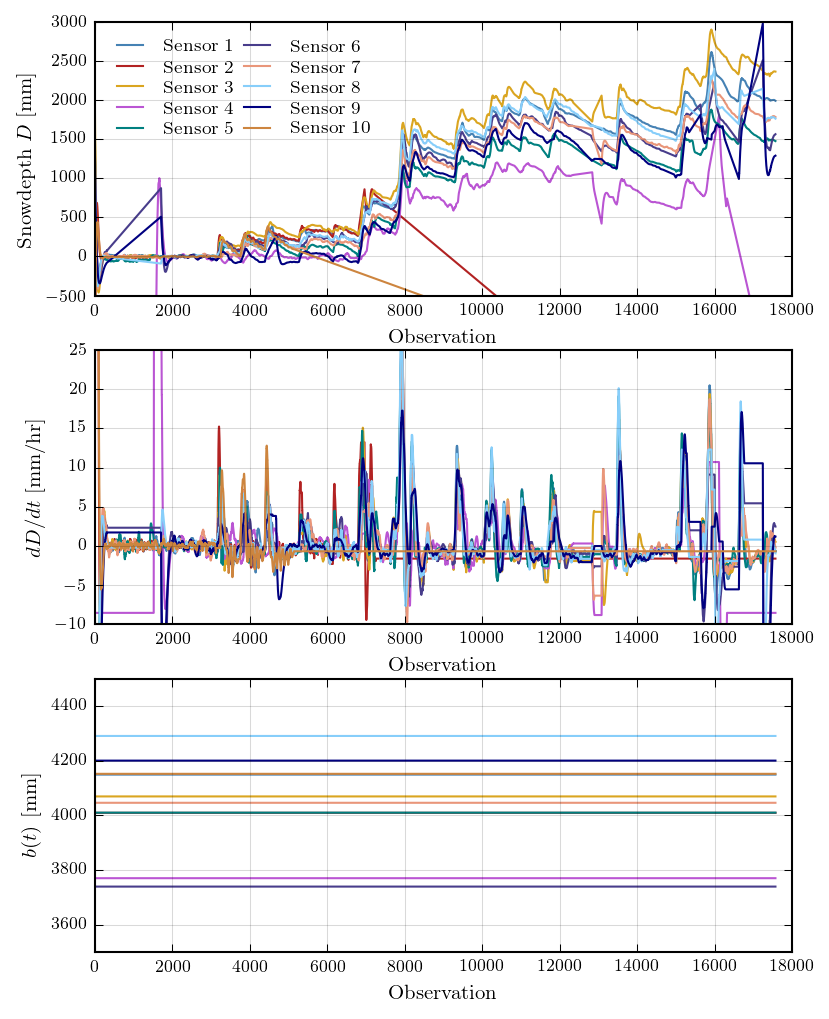

In [220]:

plt.figure(figsize=(6,8))

for i_sensor in range(nsensors):
    for i_param in range(3):
        plt.subplot(3,1,i_param+1)
        plt.plot(mu_list[:,i_sensor*3+i_param],label='Sensor %i'%(i_sensor+1))
        
        
plt.subplot(311)
# Plot the snowdepth 
plt.xlabel('Observation')
plt.ylabel('Snowdepth $D$ [mm]')
plt.grid(linestyle='-', alpha=.15)
plt.legend(loc=2, ncol=2, frameon=False, columnspacing=.2, labelspacing=.2)
plt.ylim(-500, 3000)

# -------------------------------
# Plot the velocity parameter
plt.subplot(312)
plt.xlabel('Observation')
plt.ylabel('$dD/dt$ [mm/hr]')
plt.ylim(-10,25)
plt.grid(linestyle='-', alpha=.15)

# -------------------------------
# Plot the baseline
plt.subplot(313)
plt.xlabel('Observation')
plt.ylabel('$b(t)$ [mm]')
plt.ylim(3.5e3,4.5e3)
plt.grid(linestyle='-', alpha=.15)

In [221]:
def GetDifferential(mu_list, nsensors, sensor1, sensor2):
    '''Returns the differential and differential velocity for sensor1 relative to sensor2. 
    
    Parameters
    ----------
    
    mu_list : np.array( (n_obs,len(mu)) ) 
        State parameters at each timestep
    nsensors : int 
        Number of sensors in set
    sensor1 : int 
        First sensor number (1 indexed)
    sensor2 : int
        Second sensor number (1 indexed)
        
    Returns
    ----------
    diff : np.array( len(mu) )
        The differential at each timestep in mm 
    diff_vel : np.array( len(mu) )
        The differential velocity at each timestep in mm/hr 
    '''
    if sensor1<1 or sensor2<1 or sensor1>nsensors or sensor2>nsensors:
        raise Exception('Invalid sensor index')
    
    # Number of differential parameters 
    new_params = nsensors*(nsensors-1)
    # Need to map the Delta_{i,j} into the state space (i.e. into an upper triangular matrix) 
    upper = numpy.triu_indices(nsensors, k=1)
    lookup = np.zeros((nsensors, nsensors)).astype(np.int32)
    # This lookup matrix contains the indices for the delta_{i,j}.  
    lookup[upper] = np.arange(len(upper[0]))*2 + (mu_list.shape[1]-new_params)
    # Now lookup[sensor1-1,sensor2-1]=index in state vector
    
    # Retreive the relevant state time series
    if sensor2 > sensor1: 
        idx = lookup[sensor1-1,sensor2-1]
        diff, diff_vel = -mu_list[:,idx], -mu_list[:,idx+1]
    elif sensor1 > sensor2:
        idx = lookup[sensor2-1,sensor1-1]
        diff, diff_vel = mu_list[:,idx], mu_list[:,idx+1]
    else: # This means sensor1==sensor2, so return zeros
        diff, diff_vel = np.zeros(mu_list.shape[0]), np.zeros(mu_list.shape[0])
    return diff, diff_vel
    
    

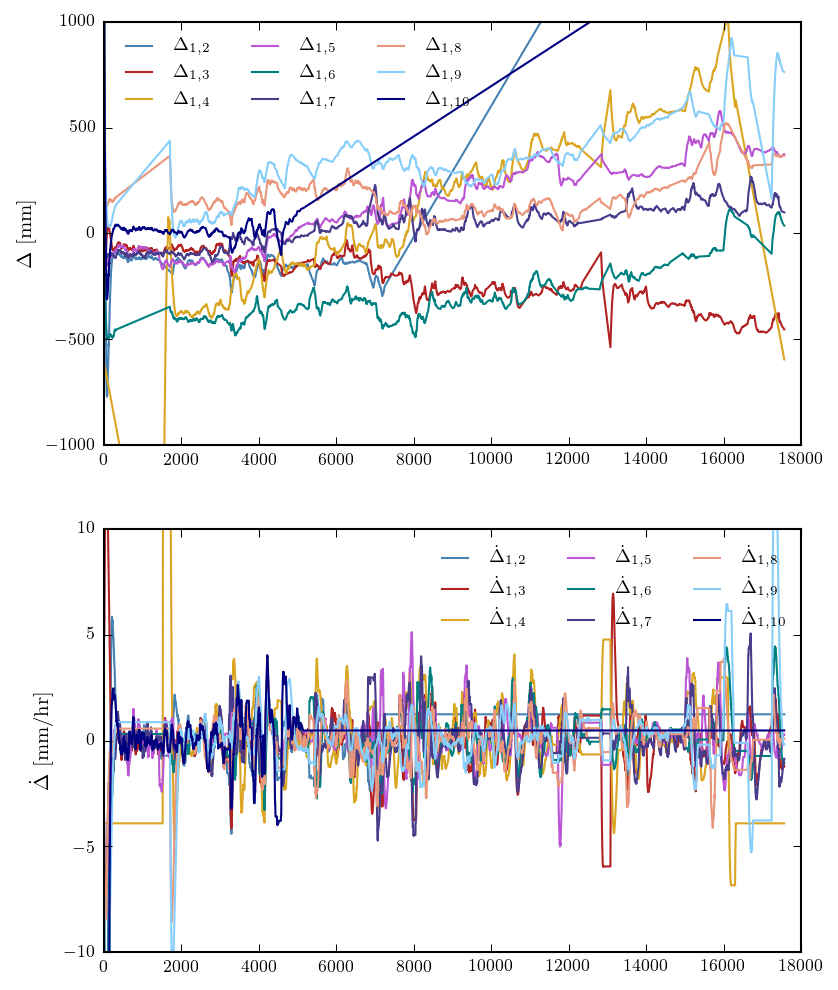

In [237]:
plt.figure(figsize=(6,8))

sensor1 = 1 
for i in range(2,11):
    diff, diff_vel = GetDifferential(mu_list, nsensors, sensor1, i)
    plt.subplot(211)
    plt.plot(diff, label=r'$\Delta_{%i,%i}$'%(sensor1,i))
    plt.subplot(212)
    plt.plot(diff_vel, label=r'$\dot{\Delta}_{%i,%i}$'%(sensor1,i))

    
plt.subplot(211)
plt.ylabel('$\Delta$ [mm]')
plt.ylim(-1000, 1000)
plt.legend(frameon=False, ncol=3, loc=2)

plt.subplot(212)
plt.ylim(-10,10)
plt.ylabel('$\dot{\Delta}$ [mm/hr]')
plt.legend(frameon=False, ncol=3)

In [183]:

# Some junk to try on smaller sets of sensors... 

import pandas as pd 
df = pd.read_pickle('../output/cluster_0_cleaned.pickle')

for i in range(4,11):
    df = df.drop('snowdepth_%i'%i, 1)
df = df.drop('snowdepth_2', 1)
#df.columns.values[-1] = 'snowdepth_3'
df.columns.values[-1] = 'snowdepth_2'
df.to_pickle('../output/cluster_0_2sensors.pickle')
